# Import Libraries

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import numpy as np
import re
import spacy
import warnings
warnings.filterwarnings('ignore')

# Text processing with nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Input
This dataset is from: https://www.kaggle.com/competitions/nlp-getting-started/data?select=test.csv

The dataset is a series of tweets, along with location and keyword data. The goal of the model is to classify if the tweet is talking about a disater or not.

## Column Description (from Kaggle)
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

# Exploratory Data Analysis


In [2]:
df = pd.read_csv("/content/data.csv") #This project was built through Google Colab, thus /content/ is on the file path 
df.head()
df.shape
2533 / 7613

0.33272034677525286

## Decode target as labels

In [3]:
decode_map = {0: "Not Disastrous", 1: "Disastrous"}
def decode_sentiment(label):
    return decode_map[int(label)]
df.loc[:, 'label'] = df.target.apply(lambda x: decode_sentiment(x))

In [4]:
df.head()

,id,keyword,location,text,target,label
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Disastrous
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Disastrous
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Disastrous
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Disastrous
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Disastrous


## Check for null values

In [5]:
print('null values in each column:\n\n', df.isnull().sum())

null values in each column:

 id             0
keyword       61
location    2533
text           0
target         0
label          0
dtype: int64


In [6]:
df.keyword.fillna('no_keyword', inplace = True)
df.location.fillna('no_location', inplace = True)
df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
label       0
dtype: int64

## Plot the data

### Number of tweets per label

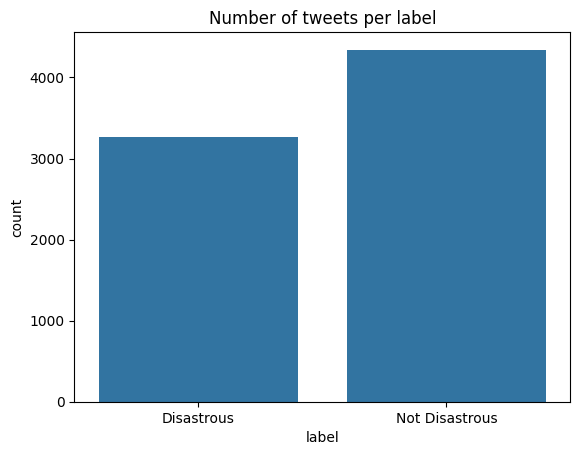

In [7]:
sns.countplot(x = 'label', data = df)
plt.title('Number of tweets per label')
plt.show()


### Top 30 Locations

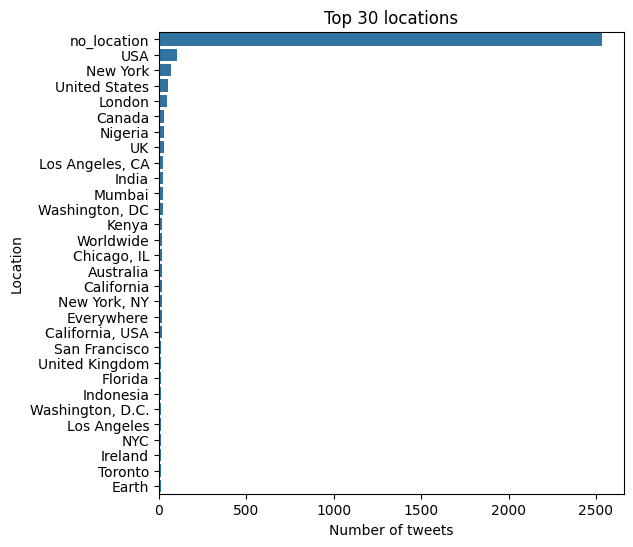

In [8]:
top_locations = df['location'].value_counts().head(30) #Get top 30 locations
plt.figure(figsize=(6, 6))
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.xlabel('Number of tweets')
plt.ylabel('Location')
plt.title('Top 30 locations')
plt.show()


# Text Preprocessing

## Filter out special characters

In [9]:
def FilterSpecialChars(text:str) -> str:
    '''
    1. Converts the text to lowercase
    2. Uses regex to remove all hyperlinks
    3. Uses regex to remove all hashtags and mentions
    4. Removes patterns
    5. Filter out punctuation
    6. Remove digits
    7. Filter out all single letters, excluding "I" and "a"
    RETURNS: cleaned text
    '''
    text = text.lower()
    text = re.sub(r"\S*https?:\S*", "", text)
    text = re.sub(r'[\#]', '', text)
    rep_character_entity_refrences = {'&amp;': '&','&lt;': '<','&gt;': '>','&quot;': '"','&apos;': "'"}
    for k,v in rep_character_entity_refrences.items():
        text = re.sub(k, v, text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub(r'\d', '', text)

    # removes all single letters surrounded with space except letters "I" and "a"
    text = re.sub(r'(?:^|\s)(?![ia])[a-z] +', ' ', text)
    return text

## Filter out common stop words

In [10]:
# spacy stopwords ("me", "you", "we", "it", "they", etc.)
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(nlp.Defaults.stop_words.copy())

# nltk stopwords ("the", "is", "at", "which", etc.)
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

# create a set of all of the stopwords
all_stopwords = set(nltk_stopwords + spacy_stopwords + ['absolutely', "actually"])

def FilterStopWords(text:str) -> str:
    '''
    1. Filter out all the stop words
    2. Combine the valid words
    RETURNS: cleaned text
    '''
    filtered_words = [word for word in text.split() if word not in all_stopwords]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Filter the DataFrame

In [11]:
def TextProcessing(df):
  df.keyword.fillna('no_keyword', inplace = True)
  df.location.fillna('no_location', inplace = True)
  # Create a new column that contains only the cleaned text
  df.loc[:, 'text_cleaned'] = df.loc[:, 'text'].apply(lambda x: FilterSpecialChars(x))
  # Create a new column that contains the cleaned text without any stopwords
  df.loc[:, 'text_cleaned_wo_stopwords'] = df.loc[:, 'text_cleaned'].apply(lambda x: FilterStopWords(x))

In [12]:
TextProcessing(df)
df.head()

,id,keyword,location,text,target,label,text_cleaned,text_cleaned_wo_stopwords
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,Disastrous,our deeds are the reason of this earthquake ma...,deeds reason earthquake allah forgive
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,Disastrous,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,Disastrous,all residents asked to shelter in place are be...,residents asked shelter place notified officer...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,Disastrous,people receive wildfires evacuation orders in...,people receive wildfires evacuation orders cal...
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,Disastrous,just got sent this photo from ruby alaska as s...,got sent photo ruby alaska smoke wildfires pou...


# Plot the cleaned data

## Most Frequent Words

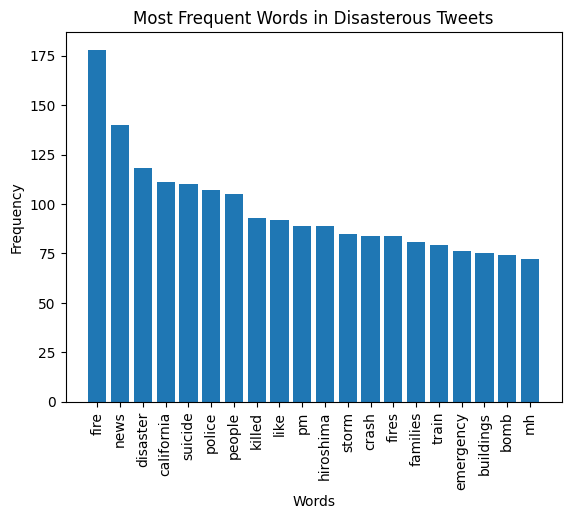

In [13]:
tokens = []
for text in df[df.target==1]['text_cleaned_wo_stopwords']:
    tokens.extend(word_tokenize(text))
freq_dist = FreqDist(tokens)
most_common_words = freq_dist.most_common(20)

words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in Disasterous Tweets")
plt.xticks(rotation=90)

plt.show()

# Implement Machine Learning Models


## Create a CountVectorizer

In [14]:
counter_vectorizer = CountVectorizer()
# Fit the df
counter_vectorizer.fit(df.text_cleaned_wo_stopwords)
# Transform the df
transformed_rows = counter_vectorizer.transform(df.text_cleaned_wo_stopwords).todense()
transformed_rows.shape

(7613, 16901)

## Pipelines

In [15]:
# Create a Ridge Classifier pipeline
ridge_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', RidgeClassifier())
])

# Create a Naive Bayes pipeline
naive_bayes_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', MultinomialNB())
])

# Create a SVM pipeline
linear_svm_pipeline = Pipeline([
    ('feature_selection', SelectKBest(f_classif, k=100)),
    ('classifier', SVC(kernel='linear'))
])

classifiers = {
    'Ridge Classifier': ridge_pipeline,
    'Naive Bayes': naive_bayes_pipeline,
    'Linear SVM': linear_svm_pipeline
}

### Comparisons

In [16]:
np.random.seed(0)
X = np.asarray(transformed_rows)
y = df.target.values.reshape(-1, 1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for name, clf in classifiers.items():
    y_pred = cross_val_predict(clf, X, y, cv=cv)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    print('-------------------------------')
    print(f'Results for {name}:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    print('-------------------------------')

-------------------------------
Results for Ridge Classifier:
Accuracy: 0.73
Precision: 0.81
Recall: 0.49
F1 Score: 0.61
Confusion Matrix:
[[3975  367]
 [1682 1589]]
-------------------------------
-------------------------------
Results for Naive Bayes:
Accuracy: 0.71
Precision: 0.86
Recall: 0.39
F1 Score: 0.53
Confusion Matrix:
[[4137  205]
 [2007 1264]]
-------------------------------
-------------------------------
Results for Linear SVM:
Accuracy: 0.73
Precision: 0.80
Recall: 0.50
F1 Score: 0.61
Confusion Matrix:
[[3928  414]
 [1637 1634]]
-------------------------------


# Make Predictions with the best Model

## Tweet Data Entry

In [17]:
keyword = "no_keyword"
location = "no_location"
text = "Typhoon Soudelor kills 28 in China and Taiwan"
tweet = pd.DataFrame({"keyword": [keyword], "location": [location], "text": [text]})

## Tweet disastrous status

In [18]:
naive_bayes_pipeline.fit(X, y)
def IsTweetDisastrous(single_df_entry):
  TextProcessing(single_df_entry)
  values = np.asarray(counter_vectorizer.transform(single_df_entry.text_cleaned_wo_stopwords).todense())
  return decode_map[int(naive_bayes_pipeline.predict(values))]

In [19]:
print(IsTweetDisastrous(tweet))

Disastrous


In [20]:
df_new = pd.read_csv("/content/test.csv") #renamed data.csv from train.csv
df_new = df_new[:2]
df_new.head()
df_new.text.iloc[0]

'Just happened a terrible car crash'

In [21]:
for i in range(len(df_new)):
  new_entry_df = pd.DataFrame({"keyword": [df_new.keyword.iloc[i]],
                               "location": [df_new.location.iloc[i]],
                               "text": [df_new.text.iloc[i]]})
  dis_result = IsTweetDisastrous(new_entry_df)
  print("Original:", new_entry_df['text'])
  print("Modified:", new_entry_df['text_cleaned_wo_stopwords'])
  print("Result:", dis_result, "\n")

Original: 0    Just happened a terrible car crash
Name: text, dtype: object
Modified: 0    happened terrible car crash
Name: text_cleaned_wo_stopwords, dtype: object
Result: Not Disastrous 

Original: 0    Heard about #earthquake is different cities, s...
Name: text, dtype: object
Modified: 0    heard earthquake different cities stay safe
Name: text_cleaned_wo_stopwords, dtype: object
Result: Disastrous 

